In [11]:
import os
import random
from matplotlib import pyplot as plt
import scipy
import sklearn
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

%run ../metric_dissimilarity.py

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
# Read training data
train_data = scipy.io.loadmat("data/train_32x32.mat")
X_train, Y_train = train_data["X"], train_data["y"].ravel()

# Read test data
test_data = scipy.io.loadmat("data/test_32x32.mat")
X_test, Y_test = test_data["X"], test_data["y"].ravel()

# Transpose
X_train = X_train.transpose(3, 0, 1, 2)
X_test = X_test.transpose(3, 0, 1, 2)

lbl_encoder = sklearn.preprocessing.LabelEncoder().fit(Y_train)
Y_train = lbl_encoder.transform(Y_train)
Y_test = lbl_encoder.transform(Y_test)

In [13]:
np.random.seed(seed)
open_set = {}
size = round(len(np.unique(Y_train)) * (4 / 10))
for kfold in range(5):
  open_set[kfold] = np.random.choice(np.unique(Y_train), size=size, replace=False)

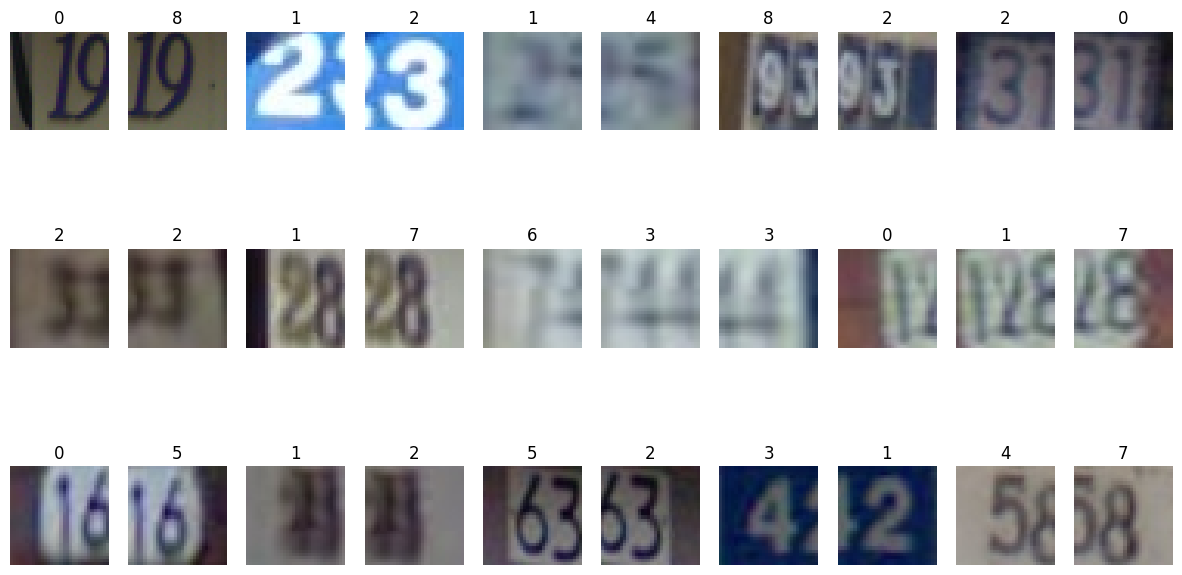

In [14]:
# Visualize some images and their corresponding labels.
plt.figure(figsize = (15, 8))
for i in range(30):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(X_train[i] / 255.)
  plt.title(Y_train[i])
  plt.axis("off")

In [15]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels, augment=True):
    self.images = images
    self.labels = labels
    self.augment = augment

    self.transform =  A.Compose([
      A.RandomCrop(28, 28),
      A.Rotate(30),
      A.GaussianBlur(),
      A.RandomBrightnessContrast(),
      A.pytorch.ToTensorV2()
    ])

    self.test_transform = A.Compose([
      A.CenterCrop(30, 30),
      ToTensorV2()
    ])

  def __len__(self):
     return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    if self.augment:
      image = self.transform(image=image)["image"]
    else:
      image = self.test_transform(image=image)["image"]

    image = image / 255.

    return image, label

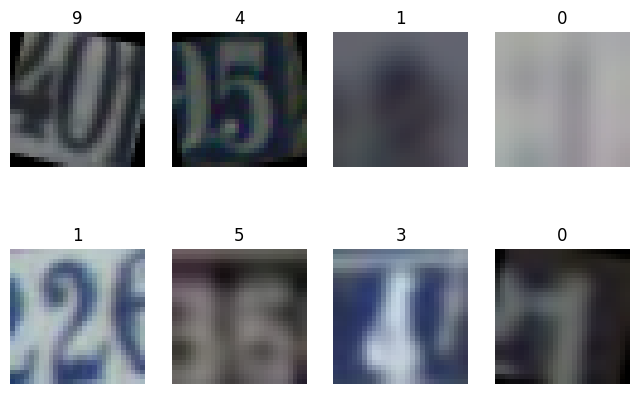

In [16]:
dataset = ImageDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
images, labels = next(iter(train_loader))

plt.figure(figsize = (8, 8))
for i in range(8):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
  plt.title(labels[i].numpy())
  plt.axis("off")

In [17]:
class VGG32(torch.nn.Module):
  def __init__(self, num_classes):
    super(VGG32, self).__init__()

    self.network = torch.nn.Sequential(
      torch.nn.Dropout(0.2),

      torch.nn.Conv2d(3, 32, 3, padding=1),
      torch.nn.BatchNorm2d(32),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Conv2d(32, 64, 3, padding=1),
      torch.nn.BatchNorm2d(64),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),
      torch.nn.BatchNorm2d(128),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Dropout(0.2),

      torch.nn.Conv2d(128, 256, 3, padding=1),
      torch.nn.BatchNorm2d(256),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Conv2d(256, 512, 3, padding=1),
      torch.nn.BatchNorm2d(512),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Conv2d(512, 1024, 3, stride=2, padding=1),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Dropout(0.2),

      torch.nn.Conv2d(1024, 1024, 3, padding=1),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Conv2d(1024, 1024, 3, padding=1),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2),

      torch.nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
      torch.nn.BatchNorm2d(1024),
      torch.nn.LeakyReLU(0.2),

      torch.nn.AdaptiveAvgPool2d((1, 1))
    )

    self.fc = torch.nn.Sequential(
      torch.nn.Linear(1024, 128),
      torch.nn.Linear(128, num_classes)
    )

  def forward(self, x):
    # Pass the input through the shared network
    x = self.network(x)
    x = x.view(x.size(0), -1)
    logits = self.fc(x)
    return logits

In [18]:
def train_model(X, Y, model_id, batch_size=128, epochs=600):

  # Define the model filename based on model_id
  model_filename = f"models/baseline-{model_id}.pth"
  print(model_filename)

  # Define computation device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Recode the output since some classes might have been removed
  Y = sklearn.preprocessing.LabelEncoder().fit_transform(Y)

  # Initialize model and optimizer
  n_classes = len(np.unique(Y))
  effnet = None

  # Load pre-trained model if exists
  if os.path.isfile(model_filename):
    effnet = VGG32(n_classes)
    effnet.load_state_dict(torch.load(model_filename, weights_only=True))
    effnet.to(device)

  # Train a new model if not loaded
  if effnet is None:

    dataset = ImageDataset(X, Y)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    effnet = VGG32(n_classes)
    effnet.to(device)

    # Initialize loss, optimizer, scheduler, and training mode
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(effnet.parameters(), lr=0.1, momentum=0.9)

    lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=20)
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=(epochs//3))
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[lr_scheduler, cosine_scheduler], milestones=[20])

    effnet.train()

    # Train
    epoch_loss = 0
    for epoch in range(epochs):
      for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = effnet(images)

        # Compute loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

      # Step scheduler
      scheduler.step()

      # Compute average epoch loss
      print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")
      epoch_loss = 0

    # Save the trained model
    torch.save(effnet.state_dict(), model_filename)

  # Freeze the model parameters
  for param in effnet.parameters():
    param.requires_grad = False

  # Set to evaluation mode
  effnet.eval()

  return effnet

In [19]:
# Model training
models = {}

# Iterate over the different openset splits
for kfold in range(5):

  # Remove the openset classes
  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  X_train_known = X_train[train_known_indices]
  Y_train_known = Y_train[train_known_indices]

  # Train the model
  models[kfold] = train_model(X_train_known, Y_train_known, kfold)

models/baseline-0.pth
models/baseline-1.pth
models/baseline-2.pth
models/baseline-3.pth
models/baseline-4.pth


In [20]:
# Prediction
np.random.seed(1234)

acc_overall = []
msp_overall = []
mls_overall = []

# Iterate over the different openset splits
for kfold in range(5):

  # Get unique classes used during training
  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  test_known_indices = ~np.isin(Y_test, open_set[kfold])

  Y_train_known = Y_train[train_known_indices]

  # Prediction
  np.random.seed(42)

  # Make predictions
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  dataset = ImageDataset(X_test, Y_test, augment=False)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

  logits = []
  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      logits.append(models[kfold](images).cpu())

  # Concatenate logits
  logits = torch.cat(logits, dim=0)
  probs = torch.nn.functional.softmax(logits, dim=1)
  preds = torch.argmax(probs, dim=1)

  # Convert back to numpy
  logits = logits.numpy()
  probs = probs.numpy()
  preds = preds.numpy()

  # Map the predictions to the known classes
  known_classes = np.unique(Y_train_known)
  preds = known_classes[preds]

  # Closed-set accuracy
  closed_acc = closed_accuracy(preds, Y_test, test_known_indices)

  # Open-set scores
  msp = compute_msp(probs)
  mls = compute_mls(logits)

  # AUROC
  msp_auroc = open_auroc(-msp, test_known_indices, ~test_known_indices)
  mls_auroc = open_auroc(-mls, test_known_indices, ~test_known_indices)

  acc_overall.append(closed_acc)
  msp_overall.append(msp_auroc)
  mls_overall.append(mls_auroc)

# Print the overall results
pct = lambda x: f"{x*100:.1f}%"
fmt = lambda x: f"{x*100:.1f}"

print("\nOverall Results:")
print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MLS AUROC':>12}")
for kfold in range(5):
  print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mls_overall[kfold]):>12}")

  # CSV
  print(f"SVHN,All,Fold {kfold},VGG32,Baseline,,Acck,,{acc_overall[kfold]}")
  print(f"SVHN,All,Fold {kfold},VGG32,Baseline,MSP,AUROC,,{msp_overall[kfold]}")
  print(f"SVHN,All,Fold {kfold},VGG32,Baseline,MLS,AUROC,,{mls_overall[kfold]}")

print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mls_overall)):<10}")
print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mls_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MLS AUROC
0            94.2%        88.8        89.7
SVHN,All,Fold 0,VGG32,Baseline,,Acck,,0.9416554465602359
SVHN,All,Fold 0,VGG32,Baseline,MSP,AUROC,,0.8875638241956707
SVHN,All,Fold 0,VGG32,Baseline,MLS,AUROC,,0.8968379007438156
1            93.5%        87.6        88.9
SVHN,All,Fold 1,VGG32,Baseline,,Acck,,0.934745277618775
SVHN,All,Fold 1,VGG32,Baseline,MSP,AUROC,,0.876350333309155
SVHN,All,Fold 1,VGG32,Baseline,MLS,AUROC,,0.8885635540856418
2            93.0%        85.3        86.4
SVHN,All,Fold 2,VGG32,Baseline,,Acck,,0.9300690825354503
SVHN,All,Fold 2,VGG32,Baseline,MSP,AUROC,,0.8525700786308074
SVHN,All,Fold 2,VGG32,Baseline,MLS,AUROC,,0.8644774336870101
3            94.3%        89.4        91.1
SVHN,All,Fold 3,VGG32,Baseline,,Acck,,0.9429744793194486
SVHN,All,Fold 3,VGG32,Baseline,MSP,AUROC,,0.8943971578124172
SVHN,All,Fold 3,VGG32,Baseline,MLS,AUROC,,0.9109597830809555
4            95.2%        89.3        90.4
SVHN,All,F